In [22]:
from lsmulator import *
from workloads import *
import numpy as np
import matplotlib.pyplot as plt
from figure_grid import *
from bloom_assignments import *
from plot_helpers import *
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors
import matplotlib.cm as cm

In [116]:
def arrows_for(savepairs):
  redist = { ('memtbl', 'cache'): np.array([1,0]),
             ('cache', 'bloom'): np.array([-.5,.5*np.sqrt(3)]),
             ('bloom', 'memtbl'): np.array([-.5,-.5*np.sqrt(3)])}
  def arrow_for(p): return redist[p] if p in redist else -redist[p[::-1]]
  return np.array([arrow_for(p) for p in savepairs])

def plot_cbm_simplex(trees,ballocs=monkey_assignment,dM=100,quiver=True,paths=False,**kwargs):
  X,Y,Z = cbm_results(trees)
  M = min(X)+max(Y)
  i = Z.argmin()
  plt.axis('equal')
  plt.axis('off')

  # convert to simplex
  C = bary_to_cartesian(np.vstack((X/M, Y/M, 1-X/M-Y/M)).T)

  # contour plot of experimental results
  plt.tricontourf(tri.Triangulation(C[:,0], C[:,1]), Z, 100, **kwargs)

  # quiver plot of estimated gradients
  if quiver:
    arrows = arrows_for(savings_pairs(trees, ballocs=ballocs))
    plt.quiver(C[:,0], C[:,1], arrows[:,0], arrows[:,1], color='black', alpha=0.5)

  if paths:
    paths = savings_paths(trees, dM=dM, ballocs=ballocs)
    for path in paths:
      plt.plot(C[path,0], C[path,1], color='yellow', alpha=0.25, lw=2)
      plt.scatter(C[path[-1],0], C[path[-1],1], color='orange', alpha=0.25, s=50)

  # experimental minimum
  plt.scatter(C[i,0], C[i,1], s=50, c=kwargs.get('color', 'yellow'))

  # dashed outline
  corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
  triangle = tri.Triangulation(corners[:, 0], corners[:, 1])
  plt.triplot(triangle, linewidth=1, linestyle='--', color='black', alpha=0.1)

  # labels
  plt.text(*[-0.05, 0], 'Buffer', {'ha': 'center', 'va': 'center'}, rotation=-60)
  plt.text(*[1.05, 0], 'Cache', {'ha': 'center', 'va': 'center'}, rotation=60)
  plt.text(*corners[2], 'Bloom', {'ha': 'center', 'va': 'center'})

def compare_cbm_trisurfs(monkey, baseline, ballocs=None, ax=None):
  if ax is None:
    ax = plt.subplot(111, projection='3d')
  plot_cbm_trisurf(monkey, color='blue')
  plot_cbm_trisurf(baseline, color='red')

def compare_cbm_contours(monkey, baseline, quiver=True, paths=False, dM=100, figsize=(10,4)):
  _x1,_y1, Z1 = cbm_results(monkey)
  _x2,_y2, Z2 = cbm_results(baseline)
  Zmin = min(Z1.min(), Z2.min())
  Zmax = max(Z1.max(), Z2.max())
  norm = matplotlib.colors.Normalize(Zmin, Zmax)

  fig = plt.figure(figsize=figsize)
  ax1 = plt.subplot(121)
  plt.title('Monkey', y=1.05)
  plot_cbm_simplex(monkey, norm=norm, ballocs=monkey_assignment, quiver=quiver, paths=paths, dM=dM)
  ax2 = plt.subplot(122)
  plt.title('Baseline', y=1.05)
  plot_cbm_simplex(baseline, norm=norm, ballocs=baseline_assignment, quiver=quiver, paths=paths, dM=dM)

  cbaxes = fig.add_axes([0.5, 0.1, 0.03, 0.8])
  cbaxes.set_title(r'$\log_{10}(Disk)$')
  m = cm.ScalarMappable()
  m.set_array(np.hstack((Z1,Z2)))
  cb = plt.colorbar(m, cax = cbaxes)

def savings_paths(trees, dM, **kwargs):
  results = cbm_results(trees).T
  savepairs = savings_pairs(trees, **kwargs)
  redist = { ('memtbl', 'cache'): np.array([-dM, dM]),
             ('cache', 'bloom'): np.array([0, -dM]),
             ('bloom', 'memtbl'): np.array([dM, 0]) }
  def redist_for(p):
    return redist[p] if p in redist else -redist[p[::-1]]
  def next_i(i):
    table1, cache1, _ = results[i]
    dt, dc = redist_for(savepairs[i])
    table2 = table1 + dt
    cache2 = cache1 + dc
    for j, (table, cache, _) in enumerate(results):
      if table == table2 and cache == cache2:
        return j
  paths = []
  for i in range(len(trees)):
    path = [i]
    visited = set([i])
    while True:
      j = next_i(i)
      if j is None or j in visited:
        break
      else:
        path.append(j)
        visited.add(j)
        i = j
    paths.append(path)
  return paths


# Optimizing Allocation

In [3]:
zipf = ZipfWorkload(zipf_param=1.25)
disc = DiscoverDecayWorkload(creates=scipy.stats.poisson(10), updates=scipy.stats.poisson(8))
unif = UniformWorkload()
rrob = RoundRobinWorkload()

def optimize(workload, total_memory, assignment, dM=100):
  return LSMulator.cache_vs_bloom_vs_buf(workload, total_memory, dM=dM, ballocs=assignment)

In [104]:
paths = savings_paths(zipf_monkey, 100)
paths

[[0, 1, 11, 20, 28, 35, 41, 45, 46],
 [1, 11, 20, 28, 35, 41, 45, 46],
 [2, 11, 20, 28, 35, 41, 45, 46],
 [3, 12, 20, 28, 35, 41, 45, 46],
 [4, 13, 21, 29, 35, 41, 45, 46],
 [5, 14, 22, 29, 35, 41, 45, 46],
 [6, 15, 23, 30, 36, 41, 45, 46],
 [7, 16, 24, 31, 37, 42, 46, 45],
 [8, 17, 25, 24, 31, 37, 42, 46, 45],
 [9, 8, 17, 25, 24, 31, 37, 42, 46, 45],
 [10, 11, 20, 28, 35, 41, 45, 46],
 [11, 20, 28, 35, 41, 45, 46],
 [12, 20, 28, 35, 41, 45, 46],
 [13, 21, 29, 35, 41, 45, 46],
 [14, 22, 29, 35, 41, 45, 46],
 [15, 23, 30, 36, 41, 45, 46],
 [16, 24, 31, 37, 42, 46, 45],
 [17, 25, 24, 31, 37, 42, 46, 45],
 [18, 17, 25, 24, 31, 37, 42, 46, 45],
 [19, 20, 28, 35, 41, 45, 46],
 [20, 28, 35, 41, 45, 46],
 [21, 29, 35, 41, 45, 46],
 [22, 29, 35, 41, 45, 46],
 [23, 30, 36, 41, 45, 46],
 [24, 31, 37, 42, 46, 45],
 [25, 24, 31, 37, 42, 46, 45],
 [26, 25, 24, 31, 37, 42, 46, 45],
 [27, 28, 35, 41, 45, 46],
 [28, 35, 41, 45, 46],
 [29, 35, 41, 45, 46],
 [30, 36, 41, 45, 46],
 [31, 37, 42, 46, 45],


## Running the simulation on a grid (cache-buffer-bloom, monkey & baseline)

In [4]:
zipf_monkey = optimize(zipf, 1000, monkey_assignment)
zipf_baseln = optimize(zipf, 1000, baseline_assignment)

In [10]:
disc_monkey = optimize(disc, 1000, monkey_assignment)
disc_baseln = optimize(disc, 1000, baseline_assignment)

In [11]:
unif_monkey = optimize(unif, 1000, monkey_assignment)
unif_baseln = optimize(unif, 1000, baseline_assignment)

In [12]:
rrob_monkey = optimize(rrob, 1000, monkey_assignment)
rrob_baseln = optimize(rrob, 1000, baseline_assignment)

In [112]:
def compare_results(distname):
  dist = eval(distname)
  monkey = eval(distname+'_monkey')
  baseln = eval(distname+'_baseln')
  compare_cbm_contours(monkey, baseln, figsize=(10,3), paths=True)
  plt.suptitle(dist, y=1.1, fontsize=16)
  plt.show()
  compare_cbm_trisurfs(monkey, baseln)
  plt.show()

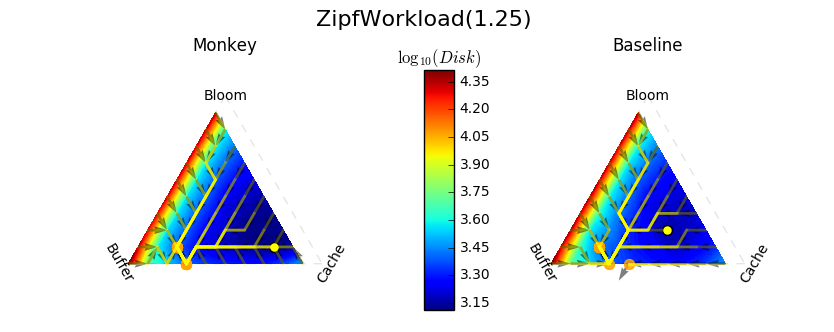

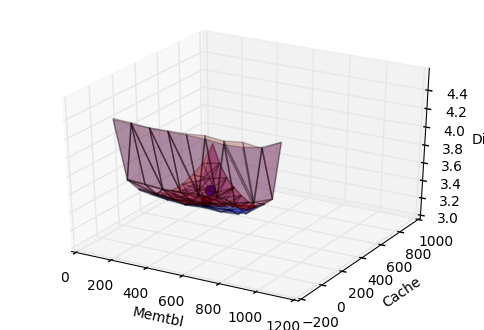

In [117]:
compare_results('zipf')

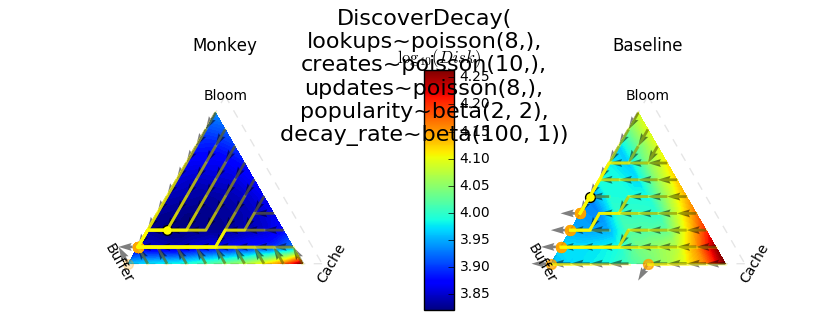

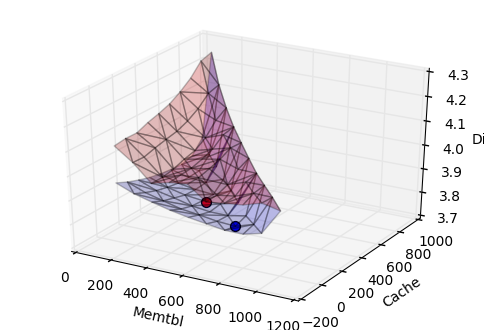

In [118]:
compare_results('disc')

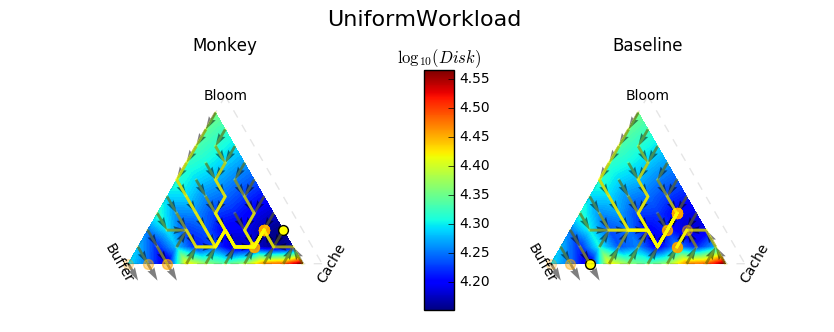

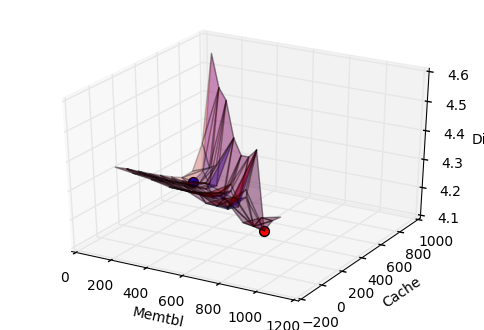

In [119]:
compare_results('unif')

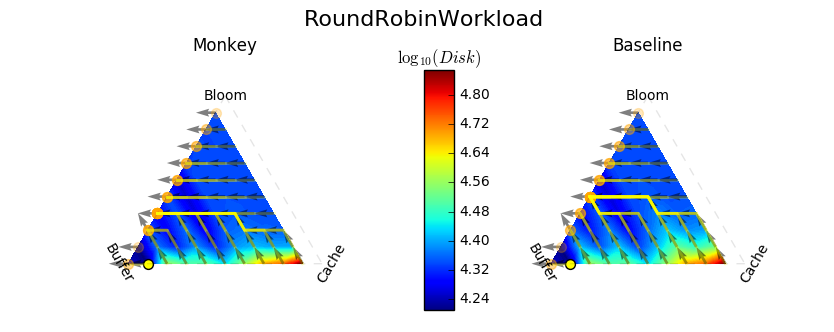

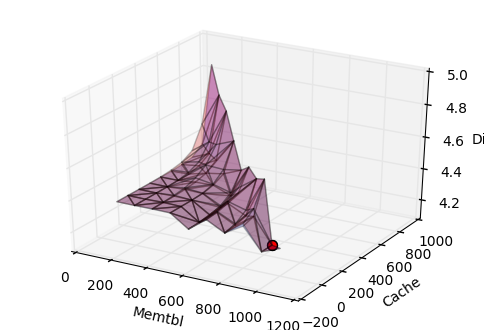

In [120]:
compare_results('rrob')

## Estimating IOs saved by enlarging cache

### What's the variance?

## Estimating IOs saved by enlarging memtable (buffer)

### What's the variance?

## Estimating IOs saved by enlarging bloom filters

### What's the variance?

## Comparing theoretical estimates to simulated results